In [ ]:
!git clone https://github.com/misbah4064/human-pose-estimation-opencv.git

fatal: destination path 'human-pose-estimation-opencv' already exists and is not an empty directory.


In [ ]:
!cd human-pose-estimation-opencv/


In [ ]:
!pip install opencv-python


In [ ]:
%cd human-pose-estimation-opencv/



/content/human-pose-estimation-opencv


In [ ]:
!ls

dance.mp4     image1.jpg  image.jpg  openpose.py  README.md
graph_opt.pb  image2.jpg  LICENSE    output.JPG


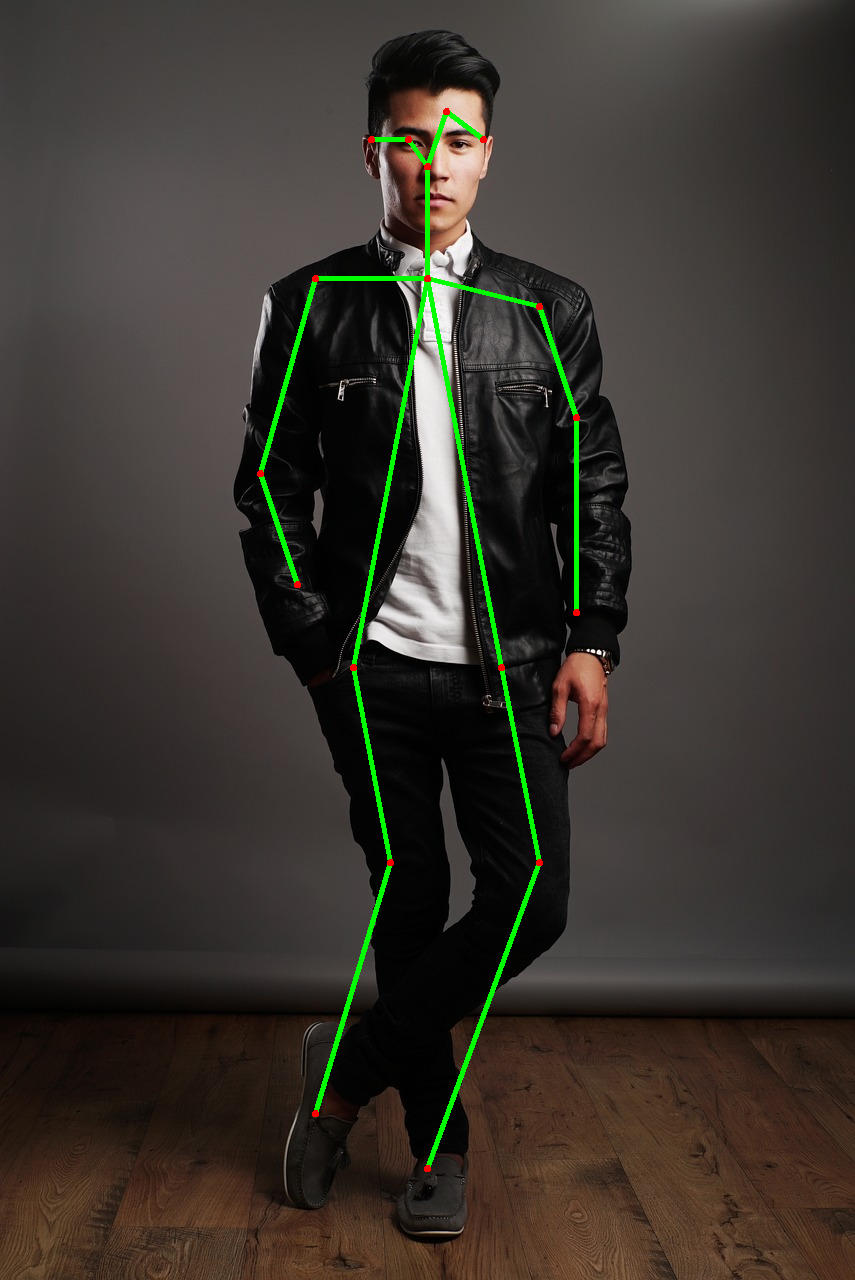

In [ ]:
# Import the necessary libraries
import cv2 as cv
import numpy as np
from google.colab.patches import cv2_imshow

# Define a dictionary mapping human body parts to their corresponding indices in the model's output
BODY_PARTS = {
    "Nose": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4,
    "LShoulder": 5, "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9,
    "RAnkle": 10, "LHip": 11, "LKnee": 12, "LAnkle": 13, "REye": 14,
    "LEye": 15, "REar": 16, "LEar": 17, "Background": 18
}

# Define a list of pairs representing the body parts that should be connected to visualize the pose
POSE_PAIRS = [
    ["Neck", "RShoulder"], ["Neck", "LShoulder"], ["RShoulder", "RElbow"],
    ["RElbow", "RWrist"], ["LShoulder", "LElbow"], ["LElbow", "LWrist"],
    ["Neck", "RHip"], ["RHip", "RKnee"], ["RKnee", "RAnkle"], ["Neck", "LHip"],
    ["LHip", "LKnee"], ["LKnee", "LAnkle"], ["Neck", "Nose"], ["Nose", "REye"],
    ["REye", "REar"], ["Nose", "LEye"], ["LEye", "LEar"]
]

# Specify the input dimensions for the neural network
width = 368
height = 368
inWidth = width
inHeight = height

# Load the pre-trained OpenPose model from a file
net = cv.dnn.readNetFromTensorflow("graph_opt.pb")
thr = 0.2  # Set a confidence threshold for detecting keypoints

# Define a function to detect poses in an input frame
def poseDetector(frame):
    frameWidth = frame.shape[1]
    frameHeight = frame.shape[0]

    # Prepare the input for the model by resizing and mean normalization
    net.setInput(cv.dnn.blobFromImage(frame, 1.0, (inWidth, inHeight), (127.5, 127.5, 127.5), swapRB=True, crop=False))
    out = net.forward()
    out = out[:, :19, :, :]  # Extract the first 19 elements, corresponding to the body part keypoints

    # Ensure the number of detected body parts matches the predefined BODY_PARTS
    assert(len(BODY_PARTS) == out.shape[1])

    points = []  # Initialize a list to hold the detected keypoints
    # Iterate over each body part to find the keypoints
    for i in range(len(BODY_PARTS)):
        # Extract the heatmap for the current body part
        heatMap = out[0, i, :, :]
        # Find the point with the maximum confidence
        _, conf, _, point = cv.minMaxLoc(heatMap)
        # Scale the point's coordinates back to the original frame size
        x = (frameWidth * point[0]) / out.shape[3]
        y = (frameHeight * point[1]) / out.shape[2]
        # Add the point to the list if its confidence is above the threshold
        points.append((int(x), int(y)) if conf > thr else None)

    # Draw lines and ellipses to represent the pose in the frame
    for pair in POSE_PAIRS:
        partFrom = pair[0]
        partTo = pair[1]
        # Ensure the body parts are in the BODY_PARTS dictionary
        assert(partFrom in BODY_PARTS)
        assert(partTo in BODY_PARTS)

        idFrom = BODY_PARTS[partFrom]
        idTo = BODY_PARTS[partTo]

        # If both keypoints are detected, draw the line and keypoints
        if points[idFrom] and points[idTo]:
            cv.line(frame, points[idFrom], points[idTo], (0, 255, 0), 3)
            cv.ellipse(frame, points[idFrom], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)
            cv.ellipse(frame, points[idTo], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)

    t, _ = net.getPerfProfile()  # Optional: Retrieve the network's performance profile

    return frame  # Return the frame with the pose drawn

# Load an input image
input = cv.imread("image1.jpg")
# Pass the image to the poseDetector function
output = poseDetector(input)
# Display the output image with the detected pose
cv2_imshow(output)